# Toxic Comment Classifier

## Introduction

In this kernel we are going to address the toxic comment classification problem, a multi-label classification problem, via various machine and deep learning techniques.\
We first start by analyzing the data. Then we try to apply techniques such as naive-bayes, logistic regressor, neural network and lstm; we even try a BERT fine tuning.\
The resulting models will then be compared based on their ROC AUC score.

In [1]:
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score

import re, string

import torchmetrics
import torch

from tqdm import tqdm
import transformers
import torchmetrics

from transformers import pipeline
from tqdm.notebook import tqdm

2023-03-29 19:56:19.605528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 19:56:20.375691: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-29 19:56:20.375774: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-29 19:56:20.375783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

## Load training and test data

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
test_labels = pd.read_csv('../input/test_labels.csv')

## Identify the classes

The comments are labelled as one or more of the following six categories: toxic, severe toxic, obscene, threat, insult and identity hate.

In [3]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

## Data analysis

The training data contains a row per comment, with an id, the text of the comment, and 6 different labels that we'll try to predict.

In [4]:
train.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
11477,1e577bd32728d079,Nina Tassler \n\nNina Tassler (Boston U: Tassl...,0,0,0,0,0,0
98138,0cf0ab44a80ef8b3,"From many parts of the Korean Peninsula, too, ...",0,0,0,0,0,0
7784,14b74c734b4c1a47,New straw poll at the content review workshop ...,0,0,0,0,0,0
50899,881b13a4acc6b8cb,"Edit request from Shawnadaisley, 1 July 2010 \...",0,0,0,0,0,0
31407,535e04801ac04610,"""\n\n Re: Star Dreadnought \n\nAttack of the C...",0,0,0,0,0,0


Here's a couple of examples of comments, one toxic (marked as toxic, obscene, insult), and one with no labels.

In [5]:
train['comment_text'][67547]

'Thankyou for blocking me you little shit \n\nThe block has now expired and I intend to get straight back to work to make up for lost time. Let the trolling and harassment commence! P.S I AM NEVER GOING TO STOP, EVER. 94.2.84.203'

In [6]:
train['comment_text'][156031]

'ALL the people who have edited that page except you and spidervenom123 seem to disagree with you on his notability. IMO Obito is arguably more notable than Itachi. Guidelines are just that: guidelines. Your unilateral actions go against consensus. Or if you are confident that consensus is on your side, please restore the article that you have effectively deleted and propose it formally at WP:PM'

First of all, let's check if there are any null values in the dataset.\
These will need to be cleaned up eventually later on.

In [7]:
train.isnull().any(),test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool,
 id              False
 comment_text    False
 dtype: bool)

All rows in the training dataset don't contain null values; specifically, they all contain comments, so there will be no need to clean up null fields.

Let's create a summary of the dataset. We also create a 'none' label so we can see how many comments have no labels.

In [8]:
train['none'] = 1-train[label_cols].max(axis=1)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The mean values are very small (some way below 0.05), as 89.8321% of the comments are not labelled in any of the six categories and therefore not considered toxic.\
Let's see the exact numbers for the various categories as well.

In [9]:
print('Total rows in train is {}'.format(len(train)))
print('Number of unlabelled (positive) comments: {}'.format(train['none'].sum()))
print(train[label_cols].sum())

Total rows in train is 159571
Number of unlabelled (positive) comments: 143346
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


As mentioned, majority of the comments in the training data are not labelled in one or more of these categories.\
Let's look at the character length for the rows in the training data.

In [10]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.0732213246768, 590.7202819048923, 5000)

The length of the comments varies a lot. Let's look at the histogram plot for text length.

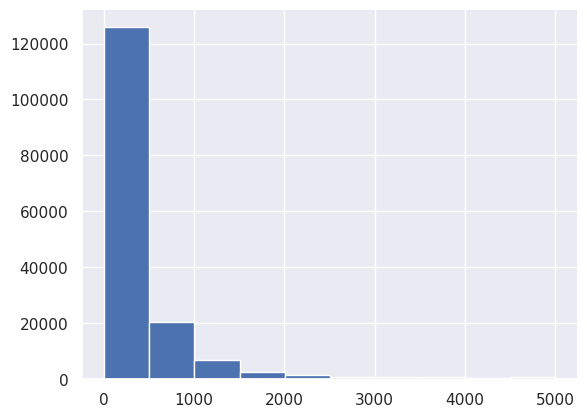

In [11]:
sns.set()
lens.hist()
plt.show()

Most of the text length are within 500 characters, with some up to 5,000 characters long.\
Next, let's examine the correlations among the target variables.

In [12]:
data = train[label_cols]

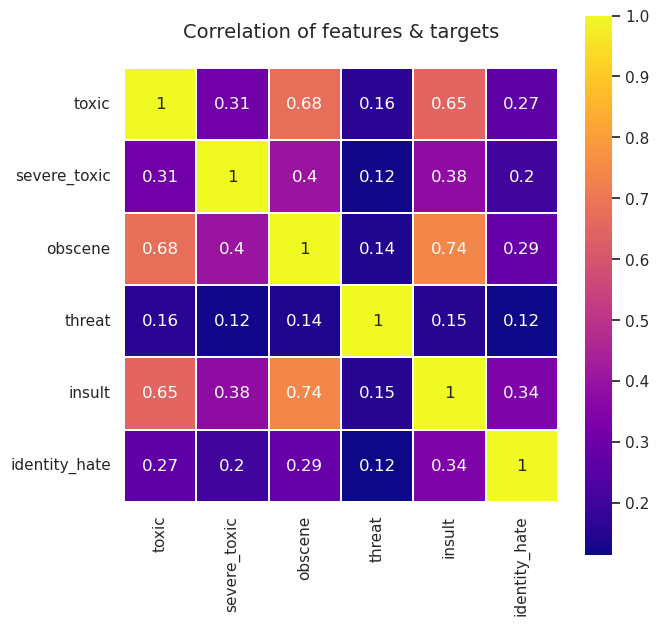

In [13]:
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True);

Indeed, it looks like some of the labels are higher correlated, e.g. insult-obscene has the highest at 0.74, followed by toxic-obscene and toxic-insult.

## Data pre-processing

### Clean test data

Rows with -1 values in test_labels are not used for evaluation.
Therefore, we remove them from test_labels and store their indexes so we can remove them from predictions as well (we need to mantain them in test, otherwise we'll have problems with indixes in predictions).

In [14]:
indexes = []
for index, row in test_labels.iterrows():
    if row['toxic'] == -1:
        indexes.append(index)
test_labels = test_labels.drop(indexes)

### Clean up the comment text

In [15]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [16]:
train['comment_text'] = train['comment_text'].map(lambda com : clean_text(com))

In [17]:
test['comment_text'] = test['comment_text'].map(lambda com : clean_text(com))

### Vectorize the data

Create a *bag of words* representation, as a *term document matrix*. We'll use ngrams, as suggested in the NBSVM paper.

In [18]:
COMMENT = 'comment_text'
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

Instantiate TfidfVectorizer.

In [19]:
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1, max_features=5000, stop_words='english' )

Learn the vocabulary in the training data, then use it to create a document-term matrix.

In [20]:
trn_term_doc = vec.fit_transform(train[COMMENT])

Transform the test data using the earlier fitted vocabulary, into a document-term matrix.

In [21]:
test_term_doc = vec.transform(test[COMMENT])

This creates a *sparse matrix* with only a small number of non-zero elements (*stored elements* in the representation  below).

In [22]:
trn_term_doc, test_term_doc

(<159571x5000 sparse matrix of type '<class 'numpy.float64'>'
 	with 3459425 stored elements in Compressed Sparse Row format>,
 <153164x5000 sparse matrix of type '<class 'numpy.float64'>'
 	with 2819639 stored elements in Compressed Sparse Row format>)

## Naive Bayes

Here we try using NBSVM (Naive Bayes - Support Vector Machine) but using sklearn's logistic regression rather than SVM, although in practice the two are nearly identical.\
NBSVM was introduced by Sida Wang and Chris Manning in the paper [Baselines and Bigrams: Simple, Good Sentiment and Topic Classiﬁcation](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf).

Here's the basic naive bayes feature equation:

In [23]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [24]:
x = trn_term_doc
test_x = test_term_doc

Fit a model for one dependent at a time:

In [25]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    #m = LogisticRegression(C=4, dual=True) # This gives an error
    m = LogisticRegression(C=4, dual=False)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [26]:
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit toxic


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fit severe_toxic


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fit obscene


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fit threat


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fit insult


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


fit identity_hate


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Model evaluation

In [27]:
test_ids = pd.DataFrame({'id': test["id"]})
predictions = pd.concat([test_ids, pd.DataFrame(preds, columns = label_cols)], axis=1)

Drop rows not used for evaluation.

In [28]:
predictions = predictions.drop(indexes)

Calculating ROC AUC score for each category.

In [29]:
for cat in label_cols:
    
    print(f"Category: {cat}")
    print(f"Sklearn score: {metrics.roc_auc_score(test_labels[cat], predictions[cat], multi_class='ovr')}")
    print(f"torchmetrics score: {torchmetrics.functional.classification.binary_auroc(torch.tensor(predictions[cat].values),torch.tensor(test_labels[cat].values), thresholds=None)}")
    print("#" * 30)
    print()

Category: toxic
Sklearn score: 0.9463812063110828
torchmetrics score: 0.9463812112808228
##############################

Category: severe_toxic
Sklearn score: 0.9788512748874643
torchmetrics score: 0.9788512587547302
##############################

Category: obscene
Sklearn score: 0.9612949041183693
torchmetrics score: 0.9612948894500732
##############################

Category: threat
Sklearn score: 0.9750306525452519
torchmetrics score: 0.9750306606292725
##############################

Category: insult
Sklearn score: 0.9516464516738289
torchmetrics score: 0.9516464471817017
##############################

Category: identity_hate
Sklearn score: 0.9634206424488436
torchmetrics score: 0.9634206295013428
##############################



Calculating mean column-wise ROC AUC score on all categories.

In [30]:
print(f"Sklearn score: {metrics.roc_auc_score(test_labels[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values, predictions[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values, average='macro')}")
print(F"Torchmetrics score: {torchmetrics.functional.classification.multilabel_auroc(torch.tensor(predictions[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values),torch.tensor(test_labels[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values),num_labels=6,thresholds=None )}")

Sklearn score: 0.9627708553308069
Torchmetrics score: 0.962770938873291


## Logistic regression
One way to approach a multi-label classification problem is to transform the problem into separate single-class classifier problems. This is known as 'problem transformation'. There are three methods:
* _**Binary Relevance.**_ This is probably the simplest which treats each label as a separate single classification problems. The key assumption here though, is that there are no correlation among the various labels.
* _**Classifier Chains.**_ In this method, the first classifier is trained on the input X. Then the subsequent classifiers are trained on the input X and all previous classifiers' predictions in the chain. This method attempts to draw the signals from the correlation among preceding target variables.
* _**Label Powerset.**_ This method transforms the problem into a multi-class problem  where the multi-class labels are essentially all the unique label combinations. In our case here, where there are six labels, Label Powerset would in effect turn this into a 2^6 or 64-class problem.

Next we will try to address the toxic classification problem using the Binary Relevance and the Classifier Chains approaches.

Instantiate the Logistic Regression model.

In [31]:
logreg = LogisticRegression(C=12.0)

Instantiate matrix to take note of predictions for test data.

In [32]:
preds = np.zeros((len(test), len(label_cols)))

### Binary Relevance

In [33]:
for i,label in enumerate(label_cols):
    print('... Processing {}'.format(label))
    y = train[label]
    # train the model using X_dtm & y
    logreg.fit(trn_term_doc, y)
    # compute the training accuracy
    y_pred_X = logreg.predict(trn_term_doc)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    preds[:,i] = logreg.predict_proba(test_term_doc)[:,1]

... Processing toxic


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9628817266295254
... Processing severe_toxic


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9919659587268363
... Processing obscene


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9830796322640079
... Processing threat


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9981575599576364
... Processing insult


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9754278659656204
... Processing identity_hate
Training accuracy is 0.9938647999949866


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Model evaluation

In [34]:
test_ids = pd.DataFrame({'id': test["id"]})
predictions = pd.concat([test_ids, pd.DataFrame(preds, columns = label_cols)], axis=1)

Drop rows not used for evaluation.

In [35]:
predictions = predictions.drop(indexes)

Calculating ROC AUC score for each category.

In [36]:
for cat in label_cols:
    
    print(f"Category: {cat}")
    print(f"Sklearn score: {metrics.roc_auc_score(test_labels[cat], predictions[cat], multi_class='ovr')}")
    print(f"torchmetrics score: {torchmetrics.functional.classification.binary_auroc(torch.tensor(predictions[cat].values),torch.tensor(test_labels[cat].values), thresholds=None)}")
    print("#" * 30)
    print()

Category: toxic
Sklearn score: 0.9427455293319935
torchmetrics score: 0.942745566368103
##############################

Category: severe_toxic
Sklearn score: 0.9736015316529021
torchmetrics score: 0.9736015796661377
##############################

Category: obscene
Sklearn score: 0.955328936678338
torchmetrics score: 0.9553288817405701
##############################

Category: threat
Sklearn score: 0.973389309732998
torchmetrics score: 0.9733892679214478
##############################

Category: insult
Sklearn score: 0.9446655855563776
torchmetrics score: 0.9446655511856079
##############################

Category: identity_hate
Sklearn score: 0.957579578839052
torchmetrics score: 0.9575796127319336
##############################



Calculating mean column-wise ROC AUC score on all categories.

In [37]:
print(f"Sklearn score: {metrics.roc_auc_score(test_labels[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values, predictions[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values, average='macro')}")
print(F"Torchmetrics score: {torchmetrics.functional.classification.multilabel_auroc(torch.tensor(predictions[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values),torch.tensor(test_labels[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values),num_labels=6,thresholds=None )}")

Sklearn score: 0.9578850786319436
Torchmetrics score: 0.9578850269317627


### Classifier Chains

Create a function to add features.

In [38]:
def add_feature(X, feature_to_add):
    '''
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    '''
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [39]:
for i,label in enumerate(label_cols):
    print('... Processing {}'.format(label))
    y = train[label]
    # train the model using X_dtm & y
    logreg.fit(trn_term_doc,y)
    # compute the training accuracy
    y_pred_X = logreg.predict(trn_term_doc)
    print('Training Accuracy is {}'.format(accuracy_score(y,y_pred_X)))
    # make predictions from test_X
    test_y = logreg.predict(test_term_doc)
    test_y_prob = logreg.predict_proba(test_term_doc)[:,1]
    preds[:,i] = test_y_prob
    # chain current label to X_dtm
    trn_term_doc = add_feature(trn_term_doc, y)
    print('Shape of X_dtm is now {}'.format(trn_term_doc.shape))
    # chain current label predictions to test_X_dtm
    test_term_doc = add_feature(test_term_doc, test_y)
    print('Shape of test_X_dtm is now {}'.format(test_term_doc.shape))

... Processing toxic


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy is 0.9628817266295254
Shape of X_dtm is now (159571, 5001)
Shape of test_X_dtm is now (153164, 5001)
... Processing severe_toxic


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy is 0.992573838604759
Shape of X_dtm is now (159571, 5002)
Shape of test_X_dtm is now (153164, 5002)
... Processing obscene


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy is 0.9849847403350233
Shape of X_dtm is now (159571, 5003)
Shape of test_X_dtm is now (153164, 5003)
... Processing threat


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy is 0.9984082320722437
Shape of X_dtm is now (159571, 5004)
Shape of test_X_dtm is now (153164, 5004)
... Processing insult


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy is 0.9824153511602985
Shape of X_dtm is now (159571, 5005)
Shape of test_X_dtm is now (153164, 5005)
... Processing identity_hate
Training Accuracy is 0.9955756371771813
Shape of X_dtm is now (159571, 5006)
Shape of test_X_dtm is now (153164, 5006)


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Model evaluation

In [40]:
test_ids = pd.DataFrame({'id': test["id"]})
predictions = pd.concat([test_ids, pd.DataFrame(preds, columns = label_cols)], axis=1)

Drop rows not used for evaluation.

In [41]:
predictions = predictions.drop(indexes)

Calculating ROC AUC score for each category.

In [42]:
for cat in label_cols:
    
    print(f"Category: {cat}")
    print(f"Sklearn score: {metrics.roc_auc_score(test_labels[cat], predictions[cat], multi_class='ovr')}")
    print(f"torchmetrics score: {torchmetrics.functional.classification.binary_auroc(torch.tensor(predictions[cat].values),torch.tensor(test_labels[cat].values), thresholds=None)}")
    print("#" * 30)
    print()

Category: toxic
Sklearn score: 0.9427455293319935
torchmetrics score: 0.942745566368103
##############################

Category: severe_toxic
Sklearn score: 0.9742395204640673
torchmetrics score: 0.9742395877838135
##############################

Category: obscene
Sklearn score: 0.946813869197702
torchmetrics score: 0.9468138217926025
##############################

Category: threat
Sklearn score: 0.971703819228728
torchmetrics score: 0.9717037677764893
##############################

Category: insult
Sklearn score: 0.9322267732963732
torchmetrics score: 0.9322267770767212
##############################

Category: identity_hate
Sklearn score: 0.9479646552970391
torchmetrics score: 0.9479646682739258
##############################



Calculating mean column-wise ROC AUC score on all categories.

In [43]:
print(f"Sklearn score: {metrics.roc_auc_score(test_labels[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values, predictions[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values, average='macro')}")
print(F"Torchmetrics score: {torchmetrics.functional.classification.multilabel_auroc(torch.tensor(predictions[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values),torch.tensor(test_labels[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values),num_labels=6,thresholds=None )}")

Sklearn score: 0.952615694469317
Torchmetrics score: 0.9526157379150391
